In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as func
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataroot = "/content/"
batch_size = 64
workers = 2
ngpu = 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -qq '/content/drive/MyDrive/interview/VMG/img_celeba_reduced.zip'

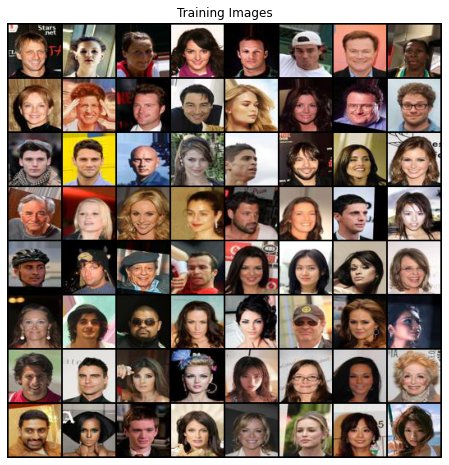

In [4]:
# We can use an image folder dataset the way we have it setup.
# dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
tmp = next(iter(dataloader))

In [6]:
tmp = tmp[0]
tmp.shape

torch.Size([64, 3, 64, 64])

# setup

In [7]:
mu = torch.rand(99,1, dtype = torch.float32, requires_grad=False).to(device)
PC = torch.rand(99,2, dtype = torch.float32, requires_grad=False).to(device)
EVpca = torch.rand(2,2, dtype = torch.float32, requires_grad=False).to(device)


illF = torch.rand(1,1,33,12, dtype = torch.float32, requires_grad=False).to(device)
illumDmeasured = torch.rand(1,1,33,22, dtype = torch.float32, requires_grad=False).to(device)

illumA = torch.rand(batch_size,1,1,33, dtype = torch.float32, requires_grad=False).to(device)
illD = torch.rand(batch_size,1,1,33, dtype = torch.float32, requires_grad=False).to(device)

illumDNorm = torch.rand(1,1,33,22, dtype = torch.float32, requires_grad=False).to(device)
illumFNorm = torch.rand(1,1,33,12, dtype = torch.float32, requires_grad=False).to(device)

Tmatrix = torch.rand(128,128,9, dtype = torch.float32, requires_grad=False).to(device)
Newskincolour = torch.rand(batch_size,256,256,33, dtype = torch.float32, requires_grad=False).to(device)

# build model

In [8]:
class enBlock(nn.Module):
    def __init__(self, in_s, out_s, double_c = True):
        super(enBlock, self).__init__()

        self.seq1 = nn.Sequential(
          nn.Conv2d(in_s, out_s, kernel_size=(3,3), stride=1, padding=1),
          nn.BatchNorm2d(out_s),
          nn.ReLU(),
        )

        self.double_c = torch.tensor(double_c, requires_grad=False)

        if self.double_c:
          self.seq2 = nn.Sequential(
            nn.Conv2d(out_s, out_s, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_s),
            nn.ReLU(),
          )

          self.seq3 = nn.Sequential(
            nn.Conv2d(out_s, out_s, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_s),
            nn.ReLU(),
          )

    def forward(self, x):
        x = self.seq1(x)
        if self.double_c:
          x = self.seq2(x)
          x = self.seq3(x)
        return x

In [9]:
class encoder(nn.Module):
    def __init__(self, double_c = True):
        super(encoder, self).__init__()
        self.b1 = enBlock(3, 32, double_c)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.b2 = enBlock(32, 64, double_c)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.b3 = enBlock(64, 128, double_c)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.b4 = enBlock(128, 256, double_c)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.b5 = enBlock(256, 512, double_c)

    def forward(self, input):
        o1 = self.b1(input)

        o2 = self.pool1(o1)
        o2 = self.b2(o2)

        o3 = self.pool2(o2)
        o3 = self.b3(o3)

        o4 = self.pool3(o3)
        o4 = self.b4(o4)

        o5 = self.pool4(o4)
        o5 = self.b5(o5)

        return o1, o2, o3, o4, o5

In [10]:
en = encoder(True).to(device)

In [11]:
o1, o2, o3, o4, o5 = en(tmp.to(device))
print(o1.shape)
print(o2.shape)
print(o3.shape)
print(o4.shape)
print(o5.shape)

torch.Size([64, 32, 64, 64])
torch.Size([64, 64, 32, 32])
torch.Size([64, 128, 16, 16])
torch.Size([64, 256, 8, 8])
torch.Size([64, 512, 4, 4])


In [12]:
class deBlock(nn.Module):
    def __init__(self, in_s, out_s, double_c = True):
        super(deBlock, self).__init__()

        self.seq1 = nn.Sequential(
            nn.Conv2d(in_s, out_s, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_s),
            nn.ReLU(),
        )

        self.double_c = torch.tensor(double_c, requires_grad=False)

        if self.double_c:
          self.seq2 = nn.Sequential(
            nn.Conv2d(out_s, out_s, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_s),
            nn.ReLU(),
          )

          self.seq3 = nn.Sequential(
            nn.Conv2d(out_s, out_s, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_s),
            nn.ReLU(),
          )

    def forward(self, x):
        x = self.seq1(x)
        if self.double_c:
          x = self.seq2(x)
          x = self.seq3(x)
        return x

In [13]:
class decoder(nn.Module):
    def __init__(self, double_c = True):
        super(decoder, self).__init__()
        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.b5 = enBlock(512+256, 256, double_c)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.b4 = enBlock(256+128, 128, double_c)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.b3 = enBlock(128+64, 64, double_c)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.b2 = enBlock(64+32, 32, double_c)
        self.conv1 = nn.Conv2d(32, 1, kernel_size=(3,3), stride=1, padding=1)

    def forward(self, o1, o2, o3, o4, o5):
        oo5 = self.up5(o5)
        oo5 = torch.cat((oo5, o4), axis = 1)
        oo5 = self.b5(oo5)

        oo4 = self.up4(oo5)
        oo4 = torch.cat((oo4, o3), axis = 1)
        oo4 = self.b4(oo4)

        oo3 = self.up4(oo4)
        oo3 = torch.cat((oo3, o2), axis = 1)
        oo3 = self.b3(oo3)

        oo2 = self.up4(oo3)
        oo2 = torch.cat((oo2, o1), axis = 1)
        oo2 = self.b2(oo2)

        oo1 = self.conv1(oo2)

        return oo1

In [14]:
class mulDecoder(nn.Module):
    def __init__(self, double_c = True):
        super(mulDecoder, self).__init__()
        self.de1 = decoder()
        self.de2 = decoder()
        self.de3 = decoder()
        self.de4 = decoder()

    def forward(self, o1, o2, o3, o4, o5):
        ooo1 = self.de1(o1, o2, o3, o4, o5)
        ooo2 = self.de1(o1, o2, o3, o4, o5)
        ooo3 = self.de1(o1, o2, o3, o4, o5)
        ooo4 = self.de1(o1, o2, o3, o4, o5)
        ooo = torch.cat((ooo1,ooo2,ooo3,ooo4), axis = 1)
        return ooo

In [15]:
de = mulDecoder(True).to(device)

In [16]:
o = de(o1, o2, o3, o4, o5)
o.shape

torch.Size([64, 4, 64, 64])

In [17]:
class fcNet(nn.Module):
    def __init__(self):
        super(fcNet, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(4,4)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 17, kernel_size=(1,1)),
        )


    def forward(self, x):
        x = self.seq(x)
        return x

In [18]:
fc = fcNet().to(device)

In [19]:
fc_o = fc(o5)
fc_o.shape

torch.Size([64, 17, 1, 1])

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss (only one iter)

## init

In [56]:
# Initialize the networks
en = encoder(True).to(device)
de = mulDecoder(True).to(device)
fc = fcNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
en.apply(weights_init)
de.apply(weights_init)
fc.apply(weights_init)

# Setup optimizers for the generator and discriminator
optimizerE = optim.SGD(en.parameters(), lr=1e-5)
optimizerD = optim.SGD(de.parameters(), lr=1e-5)
optimizerF = optim.SGD(fc.parameters(), lr=1e-5)

In [57]:
# Training Loop

num_epochs = 100
# Lists to keep track of progress
loss_1 = []
loss_2 = []
loss_3 = []
loss_4 = []
iters = 0

print("Beginning training")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
      break
    break

en.zero_grad()
de.zero_grad()
fc.zero_grad()

Beginning training


## scaling

In [58]:
# network out
data_gpu = data[0].to(device)
o1, o2, o3, o4, o5 = en(data_gpu)
fc_o = fc(o5)
de_o = de(o1, o2, o3, o4, o5)

# cct & weight
lightingweights = func.softmax(fc_o[:,0:14,0,0], dim = 1)

weightA  = lightingweights[:,0].reshape(batch_size,1,1,1)
weightD  = lightingweights[:,1].reshape(batch_size,1,1,1)
Fweights = lightingweights[:,2:14].reshape(batch_size,1,1,12)

CCT      =  fc_o[:,14,0,0].reshape(batch_size,1,1,1)
CCT      = ((22 - 1)/(1 + torch.exp(-CCT))) + 1

# b 
b = 6*torch.sigmoid(fc_o[:,15:17, 0, 0])-3
bGrid = b/3

# img
fmel = torch.sigmoid(de_o[:,[0],:,:])*2-1
fblood = torch.sigmoid(de_o[:,[1],:,:])*2-1
Shading = torch.exp(de_o[:,[2],:,:])
specmask= torch.exp(de_o[:,[3],:,:])

## illumination

In [59]:
# illumination A:
illuminantA = illumA*weightA

# illumination D:
illuminantD = illD*weightD

# illumination F:
illuminantF = illumFNorm*Fweights
illuminantF = torch.sum(illuminantF,3, keepdims= True)
illuminantF = illuminantF.permute(0, 1, 3, 2)

e = illuminantA + illuminantD +illuminantF
esums = torch.sum(e,3,keepdims = True)
e = e/esums

## camera & light colour

In [60]:
# cameraModel
S = PC.matmul(b.T) + mu
S = func.relu(S).permute(1,0)

Sr = S[:,0:33].reshape([batch_size, 1, 1, 33])               
Sg = S[:,33:66].reshape([batch_size, 1, 1, 33])     
Sb = S[:,66:99].reshape([batch_size, 1, 1, 33])     

# light colour
SSr = torch.sum(Sr*e,3,keepdims=True)
SSg = torch.sum(Sg*e,3,keepdims=True)
SSb = torch.sum(Sb*e,3,keepdims=True)
lightcolour = torch.cat((SSr, SSg, SSb), 3)

## Specularities & BiotoSpectralRef

In [61]:
# computeSpecularities ?? H x W x 3 x B
Specularities = specmask*lightcolour.permute(0,3,2,1)  

# BiotoSpectralRef
BiophysicalMaps = torch.cat((fblood, fmel), 1)
BiophysicalMaps = BiophysicalMaps.permute(0, 2, 3, 1)

R_total  = func.grid_sample(Newskincolour.permute(0,3,1,2), BiophysicalMaps, align_corners=False)

## ImageFormation

In [63]:
spectraRef = R_total*e.permute(0,3,1,2)

rChannel = torch.sum((spectraRef*Sr.permute(0,3,1,2)),1, keepdims=True) 
gChannel = torch.sum((spectraRef*Sg.permute(0,3,1,2)),1, keepdims=True)  
bChannel = torch.sum((spectraRef*Sb.permute(0,3,1,2)),1, keepdims=True)   

diffuseAlbedo = torch.cat((rChannel,gChannel,bChannel), 1)


ShadedDiffuse = diffuseAlbedo*Shading

rawAppearance = ShadedDiffuse + Specularities

## WhiteBalance

In [64]:
imWB = rawAppearance/lightcolour.permute(0,3,1,2)  

## findT & fromRawTosRGB

In [65]:
T_RAW2XYZ  = func.grid_sample(Tmatrix.reshape(1, 128, 128, 9).permute(0,3,1,2), 
                              bGrid.reshape(1, batch_size, 1, 2), align_corners=False)
T_RAW2XYZ = T_RAW2XYZ.permute(2, 0, 3, 1)

In [66]:
Txyzrgb = [[3.2406, -1.5372, -0.4986], [-0.9689, 1.8758, 0.0415], [0.0557, -0.2040, 1.057]]
Txyzrgb = torch.tensor(Txyzrgb, requires_grad=False).to(device)

In [67]:
Ix = torch.sum(T_RAW2XYZ[:,0,0,[0,3,6]].reshape(batch_size,3,1,1) * imWB, 1, keepdims = True)
Iy = torch.sum(T_RAW2XYZ[:,0,0,[1,4,7]].reshape(batch_size,3,1,1) * imWB, 1, keepdims = True)
Iz = torch.sum(T_RAW2XYZ[:,0,0,[2,5,8]].reshape(batch_size,3,1,1) * imWB, 1, keepdims = True)
Ixyz = torch.cat((Ix,Iy,Iz), 1)

R = torch.sum(Ixyz * Txyzrgb[0,:].reshape(1,3,1,1), 1, keepdims = True)
G = torch.sum(Ixyz * Txyzrgb[1,:].reshape(1,3,1,1), 1, keepdims = True)
B = torch.sum(Ixyz * Txyzrgb[2,:].reshape(1,3,1,1), 1, keepdims = True)
sRGBim = torch.cat((R,G,B), 1)
sRGBim = func.relu(sRGBim)

## loss

In [68]:
scaleRGB = sRGBim*255

In [69]:
muim = [129.1863,104.7624,93.5940]
muim = torch.tensor(muim, requires_grad=False).to(device)
muim = muim.reshape(1,3,1,1)

In [70]:
rgbim = scaleRGB - muim
# actucal shading not know, use data
actual = torch.mean(data_gpu, dim=1, keepdims=True)
actual.requires_grad_ = False
scale = torch.sum(actual*Shading, (1,2,3))/torch.sum(actual*actual, (1,2,3))

predictedShading = Shading*scale.reshape(batch_size,1,1,1);
alpha = (actual - predictedShading)

In [71]:
blossweight = torch.tensor(1e-4, requires_grad=False).to(device)
appweight = torch.tensor(1e-3, requires_grad=False).to(device)
Shadingweight = torch.tensor(1e-5, requires_grad=False).to(device)
sparseweight = torch.tensor(1e-5, requires_grad=False).to(device)

# Camera parameter loss:
priorB = torch.sum(b*b)
priorloss = priorB*blossweight

# L2: appearance loss
delta = data_gpu - rgbim
appearanceloss = torch.sum(delta*delta)/(224 * 224)*appweight

#
shadingloss = torch.sum(alpha*alpha) * Shadingweight

#  L1 sparsity loss:
sparsityloss = torch.sum(Specularities)*sparseweight
sparsityloss = sparsityloss

# Final Loss:
loss = appearanceloss + priorloss + sparsityloss +shadingloss

In [73]:
optimizerE.step()
optimizerD.step()
optimizerF.step()

# loss put them all

In [23]:
# Initialize the networks
en = encoder(True).to(device)
de = mulDecoder(True).to(device)
fc = fcNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
en.apply(weights_init)
de.apply(weights_init)
fc.apply(weights_init)

# Setup optimizers for the generator and discriminator
optimizerE = optim.SGD(en.parameters(), lr=1e-5)
optimizerD = optim.SGD(de.parameters(), lr=1e-5)
optimizerF = optim.SGD(fc.parameters(), lr=1e-5)

# Training Loop
num_epochs = 2
# Lists to keep track of progress
loss_1 = []
loss_2 = []
loss_3 = []
loss_4 = []
iters = 0

print("Beginning training")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
      if i==1:
        break

      en.zero_grad()
      de.zero_grad()
      fc.zero_grad()

      # network out
      data_gpu = data[0].to(device)
      o1, o2, o3, o4, o5 = en(data_gpu)
      fc_o = fc(o5)
      de_o = de(o1, o2, o3, o4, o5)

      # cct & weight
      lightingweights = func.softmax(fc_o[:,0:14,0,0], dim = 1)

      weightA  = lightingweights[:,0].reshape(batch_size,1,1,1)
      weightD  = lightingweights[:,1].reshape(batch_size,1,1,1)
      Fweights = lightingweights[:,2:14].reshape(batch_size,1,1,12)

      CCT      =  fc_o[:,14,0,0].reshape(batch_size,1,1,1)
      CCT      = ((22 - 1)/(1 + torch.exp(-CCT))) + 1

      # b 
      b = 6*torch.sigmoid(fc_o[:,15:17, 0, 0])-3
      bGrid = b/3

      # img
      fmel = torch.sigmoid(de_o[:,[0],:,:])*2-1
      fblood = torch.sigmoid(de_o[:,[1],:,:])*2-1
      Shading = torch.exp(de_o[:,[2],:,:])
      specmask= torch.exp(de_o[:,[3],:,:])

      # illumination A:
      illuminantA = illumA*weightA

      # illumination D:
      illuminantD = illD*weightD

      # illumination F:
      illuminantF = illumFNorm*Fweights
      illuminantF = torch.sum(illuminantF,3, keepdims= True)
      illuminantF = illuminantF.permute(0, 1, 3, 2)

      e = illuminantA + illuminantD +illuminantF
      esums = torch.sum(e,3,keepdims = True)
      e = e/esums

      # cameraModel
      S = PC.matmul(b.T) + mu
      S = func.relu(S).permute(1,0)

      Sr = S[:,0:33].reshape([batch_size, 1, 1, 33])               
      Sg = S[:,33:66].reshape([batch_size, 1, 1, 33])     
      Sb = S[:,66:99].reshape([batch_size, 1, 1, 33])     

      # light colour
      SSr = torch.sum(Sr*e,3,keepdims=True)
      SSg = torch.sum(Sg*e,3,keepdims=True)
      SSb = torch.sum(Sb*e,3,keepdims=True)
      lightcolour = torch.cat((SSr, SSg, SSb), 3)

      # computeSpecularities ?? H x W x 3 x B
      Specularities = specmask*lightcolour.permute(0,3,2,1)  

      # BiotoSpectralRef
      BiophysicalMaps = torch.cat((fblood, fmel), 1)
      BiophysicalMaps = BiophysicalMaps.permute(0, 2, 3, 1)

      R_total  = func.grid_sample(Newskincolour.permute(0,3,1,2), BiophysicalMaps, align_corners=False)

      # rgb
      spectraRef = R_total*e.permute(0,3,1,2)

      rChannel = torch.sum((spectraRef*Sr.permute(0,3,1,2)),1, keepdims=True) 
      gChannel = torch.sum((spectraRef*Sg.permute(0,3,1,2)),1, keepdims=True)  
      bChannel = torch.sum((spectraRef*Sb.permute(0,3,1,2)),1, keepdims=True)   

      diffuseAlbedo = torch.cat((rChannel,gChannel,bChannel), 1)


      ShadedDiffuse = diffuseAlbedo*Shading

      rawAppearance = ShadedDiffuse + Specularities

      imWB = rawAppearance/lightcolour.permute(0,3,1,2)  

      # xyz
      T_RAW2XYZ  = func.grid_sample(Tmatrix.reshape(1, 128, 128, 9).permute(0,3,1,2), 
                                    bGrid.reshape(1, batch_size, 1, 2), align_corners=False)
      T_RAW2XYZ = T_RAW2XYZ.permute(2, 0, 3, 1)

      Txyzrgb = [[3.2406, -1.5372, -0.4986], [-0.9689, 1.8758, 0.0415], [0.0557, -0.2040, 1.057]]
      Txyzrgb = torch.tensor(Txyzrgb, requires_grad=False).to(device)

      Ix = torch.sum(T_RAW2XYZ[:,0,0,[0,3,6]].reshape(batch_size,3,1,1) * imWB, 1, keepdims = True)
      Iy = torch.sum(T_RAW2XYZ[:,0,0,[1,4,7]].reshape(batch_size,3,1,1) * imWB, 1, keepdims = True)
      Iz = torch.sum(T_RAW2XYZ[:,0,0,[2,5,8]].reshape(batch_size,3,1,1) * imWB, 1, keepdims = True)
      Ixyz = torch.cat((Ix,Iy,Iz), 1)

      R = torch.sum(Ixyz * Txyzrgb[0,:].reshape(1,3,1,1), 1, keepdims = True)
      G = torch.sum(Ixyz * Txyzrgb[1,:].reshape(1,3,1,1), 1, keepdims = True)
      B = torch.sum(Ixyz * Txyzrgb[2,:].reshape(1,3,1,1), 1, keepdims = True)
      sRGBim = torch.cat((R,G,B), 1)
      sRGBim = func.relu(sRGBim)

      scaleRGB = sRGBim*255

      muim = [129.1863,104.7624,93.5940]
      muim = torch.tensor(muim, requires_grad=False).to(device)
      muim = muim.reshape(1,3,1,1)

      rgbim = scaleRGB - muim
      # actucal shading not know, use data
      actual = torch.mean(data_gpu, dim=1, keepdims=True)
      actual.requires_grad_ = False
      scale = torch.sum(actual*Shading, (1,2,3))/torch.sum(actual*actual, (1,2,3))

      predictedShading = Shading*scale.reshape(batch_size,1,1,1);
      alpha = (actual - predictedShading)

      blossweight = torch.tensor(1e-4, requires_grad=False).to(device)
      appweight = torch.tensor(1e-3, requires_grad=False).to(device)
      Shadingweight = torch.tensor(1e-5, requires_grad=False).to(device)
      sparseweight = torch.tensor(1e-5, requires_grad=False).to(device)

      # Camera parameter loss:
      priorB = torch.sum(b*b)
      priorloss = priorB*blossweight

      # L2: appearance loss
      delta = data_gpu - rgbim
      appearanceloss = torch.sum(delta*delta)/(224 * 224)*appweight

      #
      shadingloss = torch.sum(alpha*alpha) * Shadingweight

      #  L1 sparsity loss:
      sparsityloss = torch.sum(Specularities)*sparseweight
      sparsityloss = sparsityloss

      # Final Loss:
      loss = appearanceloss + priorloss + sparsityloss +shadingloss\

      print(loss)

      optimizerE.step()
      optimizerD.step()
      optimizerF.step()


Beginning training
tensor(3579.6040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3189.1550, device='cuda:0', grad_fn=<AddBackward0>)
